# Úkol č. 1 - vizualizace dat a web scraping (do 11. října)

  * V rámci tohoto úkolu musíte stáhnout dat z webu (tzv. _web scraping_, velmi základní) a následně data zpracovat a vizualizovat.
  * Cílem bude stáhnout data ze serveru https://www.psp.cz/sqw/hlasovani.sqw?o=8 týkající hlasování současné poslanecké sněmovny, uložit tato data v tabulkovém formátu a pak vymyslet vizualizace a zobrazení dat, které umožní orientaci v těchto datech a zvýrazní zajímavé informace a zobrazit přehledně časový vývoj různých veličin.
 
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Data

 * Měli byste stáhnout data ze všech hlasování současné poslanecké sněmovny (tj. od voleb v roce 2017) a to až na úroveň jednotlivých poslanců. 
 * Data by měla obsahovat i stručný popis toho, o jaké hlasování šlo.

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * Strojově stáhněte data a uložte je do vhodného formátu, který se Vám bude dále dobře zpracovávat. 
  * **I když nemusíte mít sněmovnu rádi, snažte se nezahltit server a mezi požadavky na stránku mějte alespoň vteřinu mezeru.**
  * V druhé části Vašeho Jupyter notebooku pracujte se staženými daty v souborech, které jsou výsledkem Vašeho stahovacího skriptu (aby opravující nemusel spouštět stahování z webu).
  * S využitím vybraných nástrojů zpracujte data a vymyslete vizualizace a grafy, aby bylo vidět následující:
    * Odchody a přeběhnutí poslanců mezi jednotlivými stranami.
    * Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek.
    * Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně.
    * Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové).

**Další body zadání** za případné další body (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * Ve vizualizacích a grafech nějak zachyťte časový vývoj (např. jak se mění docházka, shoda mezi stranami atp.).
  * Najděte jednotlivé poslance, kteří se nejvíce shodují při svém hlasování či kteří mají co nejpodobnější účast na hlasování.
  * Zkuste rozlišit v datech důležitá hlasování a zpracujte vizualizace (také) pro ně.
  * Zkuste najít hlasování, kde poslanci hlasovali nejvíce jinak, než obvykle.
  
## Tipy a triky
  * Balíčky iportujte na začátku notebooku (příp. na začátku scrapovací a pak na začátku vizualizační části).
  * Využívejte markdown buňky (jako je ta, ve které je tento text) a naspisy, abyste usnadnily orientaci opravující(mu).
  * Pečlivě si vybírejte grafy a vizualizace, aby co nejlépe vyjádřily to, co vyjádřit chcete. Doporučuji projít si pro inspiraci alespoň galerie balíčků `matplotlib` a `seaborn`.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook (příp. doplněn skripty), ale i soubor(y) se staženými daty (ať opravující nemusí stahovat data).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_votes = pd.read_csv('./data/deputy_votes.csv', encoding='windows-1250')
df_voting = pd.read_csv('./data/sessions.csv', encoding='windows-1250', index_col='vote_id')

# Data mapping
To make the code more legible, the constants representing a deputy's vote have been mapped to sensible values

In [3]:
df_votes['vote'].replace( {'A':'Yes',
                           'N':'No',
                           '0':'Not logged in',
                           'M':'Excused',
                           'Z':'Refrained'}, inplace=True)

# Odchody a přeběhnutí poslanců mezi jednotlivými stranami.

In [4]:
#Find the most frequent turncoat

party_allegiances = df_votes.groupby('name')['party'].nunique()

turncoat_count = party_allegiances.max()
turncoat_name = party_allegiances.idxmax()
print('The biggest turncoat was {}, swapping parties {} times.'.format(turncoat_name, turncoat_count))

The biggest turncoat was Jaroslav Foldyna, swapping parties 3 times.


In [5]:
voting_ids = df_voting.index.to_list()

parties_per_session = {}

for id in voting_ids:
    parties_per_session[id] = df_votes.loc[df_votes['vote_id'] == id]['party'].values

turncoats = party_allegiances[party_allegiances > 1].index # names of all deputies which had changed their allegiance

In [6]:
# Find all the breaking points, at which a deputy has a different party from the previous session

events = {df_votes['vote_id'].min(),df_votes['vote_id'].max()}
for turncoat in turncoats:
    turncoat_meetings = df_votes[ df_votes['name'].eq(turncoat)] # all the turncoat's meetings
    
    og_party = turncoat_meetings.iloc[0]['party'] # first session's party allegiance
    
    event = turncoat_meetings[turncoat_meetings['party'].ne(og_party)].iloc[0]['vote_id']
    events.add(event)

events = list(events) # all the important sessions (== the ones where a deputy's allegiance changed), as well as a starting point and an ending point are in this list
events.sort()

In [7]:
displayed_sets = [] # displayed values of the chart
for event in events:
    votes = df_votes[df_votes['vote_id'] == event]['party'].values
    displayed_sets.append({'label': str(event),
                           'values': votes})
    
fig = go.Figure(layout = go.Layout(title='Deputy party change'),
                data=go.Parcats(dimensions = displayed_sets, arrangement='freeform'))
fig.show()

# Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně.


In [8]:
parties = df_votes['party'].unique()

dummy = pd.DataFrame({'count':df_votes.groupby(['vote_id','party','vote']).size()}).reset_index() # create a new table with numbers of count for each session, party & vote
dummy = dummy[ dummy['vote'].isin(['Yes','No','Refrained'])] # filter

In [9]:
df_v = pd.merge(dummy,dummy.groupby(['vote_id','party'])['count'].sum(),on=['vote_id','party'])
print(df_v)
''' This is slightly complicated. The list is reordered by the number of votes descending. As such, the first value with the same vote_id and party will always be higher
    Then, anything with the identical key = vote_id, party is droppped. Due to the way the data is ordered, only the votes with the highest count are kept
    Finally, the frame is reordered by the key = vote_id, party
    tl;dr find and keep the max value for each key = vote_id, party
'''
df_v = df_v.sort_values('count_x',ascending=False).drop_duplicates(['vote_id','party']).sort_values(['vote_id','party']).drop(columns=['count_x','count_y'])

matrix = pd.DataFrame(0,index = parties,columns = parties)

# construct the heatmap matrix
a = df_v.groupby(['vote_id','vote'])
for key, item in a:
    allies = a.get_group(key)['party'] # all parties in accord for a session
    for first_party in allies.values: #
        for second_party in allies.values:
            matrix.at[first_party,second_party] += 1
            
matrix = ( (matrix-matrix.min()) / (matrix.max()-matrix.min()) ) # normalise
matrix = matrix.drop(columns=['Nezařaz']).drop(['Nezařaz']) # drop the non-party votes

        vote_id    party       vote  count_x  count_y
0         67018      ANO  Refrained        2       76
1         67018      ANO        Yes       74       76
2         67018  KDU-ČSL  Refrained        1       10
3         67018  KDU-ČSL        Yes        9       10
4         67018     KSČM        Yes       14       14
...         ...      ...        ...      ...      ...
101530    74002      SPD        Yes       10       10
101531    74002     STAN        Yes        2        2
101532    74002    TOP09  Refrained        2        2
101533    74002     ČSSD         No        1        6
101534    74002     ČSSD        Yes        5        6

[101535 rows x 5 columns]


In [10]:
ax = plt.axes()
sns.heatmap(matrix, annot=True, ax=ax)
ax.set_title('Party voting correlation')
plt.show()

In [11]:
# Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek.

In [12]:
actual_size_per_session = df_votes [ df_votes['vote'].isin(['Yes','No','Refrained'])].groupby(['vote_id','party']).size() # count per session per party attendance
parties_size_per_session = df_votes.groupby(['vote_id','party']).size() # count party's size, including non-present deputies
percentual_attendance = 100 * actual_size_per_session / parties_size_per_session # ratio

percentual_attendance = percentual_attendance.reset_index().drop(columns='vote_id').groupby('party').mean().rename(columns={0:'attendance'}).sort_values('attendance',ascending=False)
fig = percentual_attendance.plot.bar()
fig.set(xlabel='Party',ylabel='Attendance %',title='Percentual attendance of parties')
plt.show()

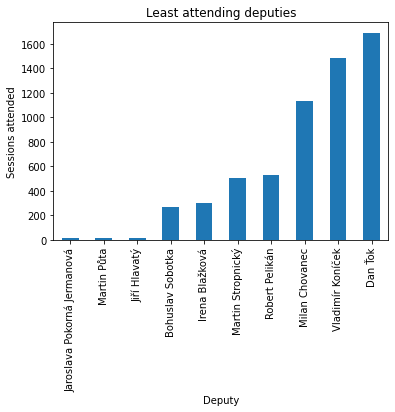

In [13]:
attendance_freq = df_votes[ df_votes['vote'].isin(['Yes','No','Refrained'])].groupby('name').size().sort_values()

fig = attendance_freq.tail(10).plot.bar()
fig.set(xlabel='Deputy',ylabel='Sessions attended', title = 'Most attending deputies')
plt.show()

fig = attendance_freq.head(10).plot.bar()
fig.set(xlabel='Deputy',ylabel='Sessions attended',title='Least attending deputies')
plt.show()

# Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové).

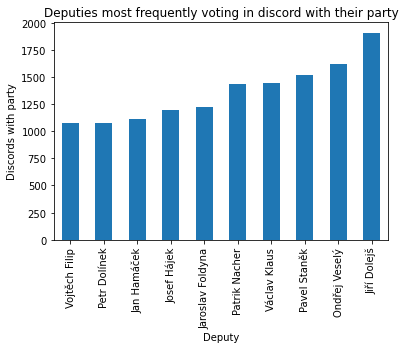

In [14]:
df_i = pd.DataFrame({'count':df_votes.groupby(['vote_id','party','vote']).size()}).reset_index()

# as above, find the maximum for each key = vote_id, party
majority_votes = df_i[df_i['vote'].isin(['Yes','No','Refrained'])].sort_values('count',ascending=False).drop_duplicates(['vote_id','party']).sort_values(['vote_id','party']).drop(columns='count')

# individual present deputies' votes
present_votes = df_votes[df_votes['vote'].isin(['Yes','No','Refrained'])]

# inner join
merged = pd.merge(present_votes ,majority_votes,on=['vote_id','party'])

rebels = merged [ merged['vote_x'] != merged['vote_y']].groupby('name').size().sort_values().tail(10)
comrades = merged [ merged['vote_x'] == merged['vote_y']].groupby('name').size().sort_values().tail(10)

fig = rebels.plot.bar()
fig.set(xlabel='Deputy',ylabel='Discords with party',title='Deputies most frequently voting in discord with their party')
plt.show()
fig = comrades.plot.bar()
fig.set(xlabel='Deputy',ylabel='Accords with party', title='Deptueis most frequently voting in accord with their party')
plt.show()